# CHB: 1. Image Classification Model

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.regularizers as tfr
import tensorflow.keras.metrics as tfm
import tensorflow_addons as tfa

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
# sns.set_theme(style="whitegrid")

import h5py
from PIL import Image
import imghdr


from itertools import islice

import pathlib
import os

In [2]:
# what's the version of your TensorFlow
print(tf.__version__)

# check whether you have a TF compatible GPU
tf.config.experimental.list_physical_devices('GPU')

2.9.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# fix the MEM error (which says GPU MEM is full)
gpus = tf.config.list_physical_devices('GPU')

# to set memory growth limit for each GPU (if have more than one)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Define Custom Funcs

### Funcs for Plotting

In [91]:
# define matplotlib, seaborn configs

# mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metrics:list):
  '''
  args:
      history: the output of model.fit()
  
  returns:
      a multi plot of the performance of the model
  '''
  plt.figure(figsize=(12, 10))
  # take the ceiling of #metrics provided as the #rows
  plot_height = int(len(metrics) / 2) + 1

  for i, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(plot_height,2,i+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.tight_layout();
  

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

## Create Dataset
> from images

### for binary classification
> class 0: Need Restoration, class 1: No Need Restoration

In [5]:
# define the dir (containing the pics)

# method 1 (caveman): use only os.path (don't use as the following cells need pathlib.Path)
# data_dir = os.path.join(image_dir, 'data', '')

# method 2 (sophi): use pathlib (has many facilites)
# data_dir = pathlib.Path(os.path.join('data', ''))
# data_dir = pathlib.Path('/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/1. Image Classification')
data_dir = pathlib.Path(os.path.join('..', '..', '..', '..', '..','Thesis Data', 'Pix', '0 Model Ready Data', '1. Image Classification', ''))
print('data_dir:', data_dir)

data_dir: ../../../../../Thesis Data/Pix/0 Model Ready Data/1. Image Classification


In [6]:
jpg_image_count = len(list(data_dir.glob('*/*.jpg')))
JPG_image_count = len(list(data_dir.glob('*/*.JPG')))
jpeg_image_count = len(list(data_dir.glob('*/*.jpeg')))
png_image_count = len(list(data_dir.glob('*/*.png')))
PNG_image_count = len(list(data_dir.glob('*/*.PNG')))

print('jpg image_count:', jpg_image_count)
print('JPG image_count:', JPG_image_count)
print('jpeg image_count:', jpeg_image_count)
print('png image_count:', png_image_count)

print(f'total images in data dir:', (jpg_image_count + JPG_image_count + jpeg_image_count + png_image_count))
print(f'total files in data dir:', len(list(data_dir.glob('*/*'))))

jpg image_count: 536
JPG image_count: 828
jpeg image_count: 343
png image_count: 19
total images in data dir: 1726
total files in data dir: 1727


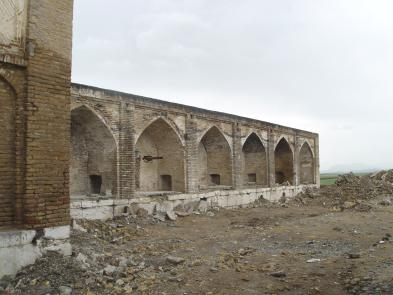

In [7]:
# show an image from a desired class (before creating a dataset & resizing)

label = 'YES'  # define the desired class/label
class_imgs_paths = list(data_dir.glob(f'*{label}*/*'))  # get all img_paths in the desired label dir
rand_index = np.random.randint(low=0, high=len(class_imgs_paths))  # take a random index

# if the filepaths were not string use Image.open(str(filepath))
an_img = Image.open(class_imgs_paths[rand_index])  # open/import the image (like plt.imread())
display(an_img)  # display the image (like plt.imshow())

In [8]:
# Check for files that are not image , or that are not what their extension says they are
# to avoid futere bugs/erros

import imghdr

supported_types = ["bmp", "gif", "jpeg", "png"]  # the image types supported by TF

# # method 1 (stackoverflow)
# img_extensions = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions (existent in data_dir)
# not_img = []  # to be filled with files that are not img
# not_supported_by_tf = []  # to be filled with unsupported img files (by TF)

# for filepath in pathlib.Path(data_dir).rglob("*"):  # get all the files in the 'data_dir'
#     if filepath.suffix.lower() in img_extensions:  # check if the file has one the provided img_extensions
#         img_type = imghdr.what(filepath)  # get the file's type
#         if img_type is None:  # if the file was not an img
#             not_img.append(filepath)
#             print(f"{filepath} is not an image")
#         elif img_type not in supported_types:  # if the file is an img but not supported by TF
#             not_supported_by_tf.append(filepath)
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
# print('-'*79)

# method 2 (tekboart): doesn't need us to define file extensions in data_dir (namely var img_extensions)
# so this method check all files (not just the provided extentions)
not_img = []  # to be filled with files that are not img
not_supported_by_tf = []  # to be filled with unsupported img files (by TF)

for filepath in pathlib.Path(data_dir).rglob("*"):  # get all the files in the 'data_dir'
    if filepath.suffix.lower().startswith('.'):  # check if filepath is a file (not a dir)
        img_type = imghdr.what(filepath)  # get the file's type
        if img_type is None:  # if the file was not an img
            not_img.append(filepath)
            print(f"{filepath} is not an image")
        elif img_type not in supported_types:  # if the file is an img but not supported by TF
            not_supported_by_tf.append(filepath)
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

print('-'*79)

# remove these files from dirs (permanently)
filepaths_to_rm = [*not_img, *not_supported_by_tf]
print('#files to be removed:', len(filepaths_to_rm))

for filepath in filepaths_to_rm:
    print("removed", filepath)
    # os.remove(filepath)  # uncomment only if you are sure about the removal

-------------------------------------------------------------------------------
#files to be removed: 0


In [9]:
# define the batch_size
# this is important to ensure that each batch has a decent chance of containing a few inferior label samples (i.e., NO restoration label). 
# If the batch size was too small, they would likely have no inferior label samples to learn from.
batch_size = 32

# define the image size (after resizing)
# input_shape = (64, 64, 3)
# input_shape = (150, 150, 3)
input_shape = (224, 224, 3)  # for MobileNet_v2 pretrained on ImageNet

print('\033[92m creating train set \033[0m'.center(79, '-'))
# must use the same seed for train, val, test sets, otherwise they might overlap (as the process becomes random)
train_ds_temp = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    label_mode='int',
    class_names=['NO restoration', 'YES restoration'],
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(input_shape[0], input_shape[1]),
    crop_to_aspect_ratio=False,
    shuffle=True,  # default True
    batch_size=batch_size)  # default 32

print('\033[91m creating val set \033[0m'.center(79, '-'))
val_ds_temp = tf.keras.utils.image_dataset_from_directory(
    directory=data_dir,
    label_mode='int',
    class_names=['NO restoration', 'YES restoration'],
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(input_shape[0], input_shape[1]),
    crop_to_aspect_ratio=False,
    shuffle=True,
    batch_size=batch_size)


------------------------- creating train set -------------------------
Found 1736 files belonging to 2 classes.
Using 1389 files for training.
-------------------------- creating val set --------------------------
Found 1736 files belonging to 2 classes.
Using 347 files for validation.


In [10]:
# define final train, val and test sets

train_ds_orig = train_ds_temp

# determine how many batches of data are available in the validation set 
val_batches = tf.data.experimental.cardinality(val_ds_temp).numpy()
print('#mini_batches in val_ds_temp:', val_batches)

# define final test set
# by moving 20% of them to a test set.
# (remember: 34 * 20 / 100 == 34 / 5)
# test_ds_orig = val_ds_temp.take(val_batches // 5)
test_ds_orig = val_ds_temp.take(int(val_batches * .2))
print('#mini_batches in val_ds_orig:', test_ds_orig.cardinality().numpy())

# define final val set
# val_ds_orig = val_ds_temp.skip(val_batches // 5)
val_ds_orig = val_ds_temp.skip(int(val_batches * .2))
print('#mini_batches in val_ds_orig:', val_ds_orig.cardinality().numpy())

#mini_batches in val_ds_temp: 11
#mini_batches in val_ds_orig: 2
#mini_batches in val_ds_orig: 9


In [11]:
# method 1 (slow)
# num_classes = len({label.numpy() for elem in train_ds_orig for label in elem[1]})
# method 2 (fast): works only with datasets created with keras.utils
num_classes = len(train_ds_orig.class_names)
print(dict(zip(train_ds_orig.class_names, range(num_classes))), end="\n\n")

# Give weights to diff classes
# calc the #recs (in all mini_batches) for each label (i.e., NO/YES) for each set
train_label_no = sum(np.sum(elem[1].numpy() == 0) for elem in train_ds_orig)
train_label_yes = sum(np.sum(elem[1].numpy() == 1) for elem in train_ds_orig)

val_label_no = sum(np.sum(elem[1].numpy() == 0) for elem in val_ds_orig)
val_label_yes = sum(np.sum(elem[1].numpy() == 1) for elem in val_ds_orig)

test_label_no = sum(np.sum(elem[1].numpy() == 0) for elem in test_ds_orig)
test_label_yes = sum(np.sum(elem[1].numpy() == 1) for elem in test_ds_orig)

neg = train_label_no + val_label_no + test_label_no
pos = train_label_yes + val_label_yes + test_label_yes
total = neg + pos

print(f'Examples:\n    Total: {total}\n    label 0 (Negative): {neg} ({(neg / total)*100:.2f}% of total)\n    label 1 (Positive): {pos} ({(pos / total)*100:.2f}% of total)\n')

{'NO restoration': 0, 'YES restoration': 1}

Examples:
    Total: 1734
    label 0 (Negative): 629 (36.27% of total)
    label 1 (Positive): 1105 (63.73% of total)



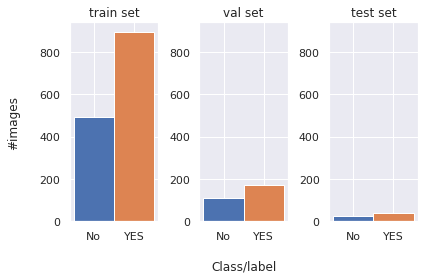

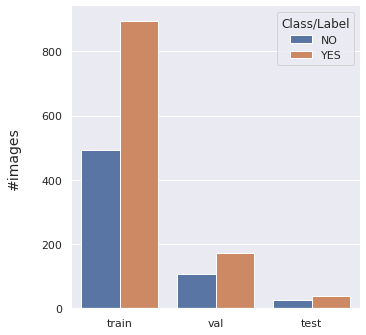

In [12]:
# visualize the label/class distributin in diff data sets

x = [train_label_no, train_label_yes, val_label_no, val_label_yes, test_label_no, test_label_yes]
max_recs = max(x)

# using matplot
plt.subplot(1, 3, 1)
plt.bar('No', train_label_no, width=1)
plt.bar('YES', train_label_yes, width=1)
plt.title('train set')
plt.ylabel('#images\n', fontsize=12)
plt.ylim(0, max_recs+max_recs*0.05)

plt.subplot(1, 3, 2)
plt.bar('No', val_label_no, width=1)
plt.bar('YES', val_label_yes, width=1)
plt.title('val set')
plt.xlabel('\nClass/label', fontsize=12)
plt.ylim(0, max_recs+max_recs*0.05)

plt.subplot(1, 3, 3)
plt.bar('No', test_label_no, width=1)
plt.bar('YES', test_label_yes, width=1)
plt.title('test set')
plt.ylim(0, max_recs+max_recs*0.05)

plt.tight_layout()
plt.show()

# using pandas + seaborn
df = pd.DataFrame({'set': ['train', 'train', 'val', 'val', 'test', 'test'], 'label': ['NO', 'YES']*3, 'recs': x})
# display(df)

g = sns.catplot(
    data=df,
    x="set",
    y="recs",
    hue="label",
    kind="bar",
    height=5,
    ci="sd", 
    # palette='husl', # set the color palette
    # alpha=0.6,  # set the opacity
)

sns.set(style="darkgrid")
g.despine(left=True)
g.set_axis_labels("", "#images\n", fontsize=14)
# g.legend.set_title("class/label", )
g._legend.remove()  # to remove sns automatic legend (and use matplot's)
plt.legend(loc='upper right', title='Class/Label')
plt.show()

In [13]:
# calc the weight of each calss

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / num_classes)
weight_for_1 = (1 / pos) * (total / num_classes)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.38
Weight for class 1: 0.78


In [14]:
# Check the resulting dataset shapes
# shows None (in shapes) if the #elsms in the last mini_batch < batch_size
print('each elem\'s images shape:', train_ds_orig.element_spec[0].shape)
print('each elem\'s labels shape:', train_ds_orig.element_spec[1].shape)

print('.'*79)

# method 2 (sophi): doesn't show None in shapes
images_batch, labels_batch = next(iter(train_ds_orig))
print('each elem\'s images shape:', images_batch.shape)
print('each elem\'s labels shape:', labels_batch.shape)

# # could use a for-loop too (TF documentation) (but caveman)
# for images_batch, labels_batch in train_ds:
#     print('each elem\'s images shape:', images_batch.shape)
#     print('each elem\'s labels shape:', labels_batch.shape)
#     break

print('-'*79)

# print the labels/classes
class_names = train_ds_orig.class_names
print("the classes/labels:", class_names)

each elem's images shape: (None, 224, 224, 3)
each elem's labels shape: (None,)
...............................................................................
each elem's images shape: (32, 224, 224, 3)
each elem's labels shape: (32,)
-------------------------------------------------------------------------------
the classes/labels: ['NO restoration', 'YES restoration']


##### Visualize the created img datasets

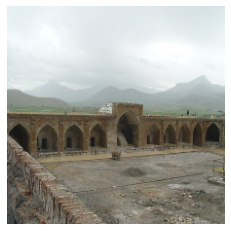

In [15]:
# take a single image from a mini_batch (in train_ds)
# i.e., the 1st img from the first batch
an_img = next(iter(train_ds_orig))[0][0]

plt.imshow(an_img.numpy().astype('uint8'))
plt.axis('off')
plt.show()

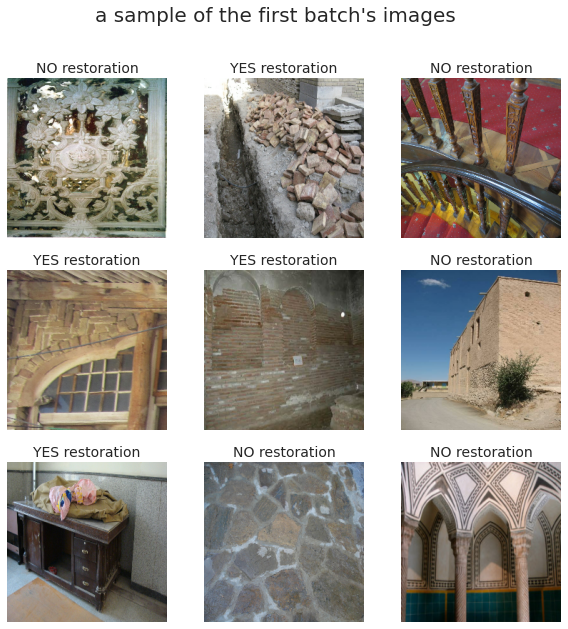

In [163]:
# Show some sample images
class_names = train_ds_orig.class_names

# method 2 (tekboart): no for-loop
plt.figure(figsize=(10, 10))

images, labels = next(iter(train_ds_orig))  # take a mini_batch (i.e., a tuple) and unpack it (images_batch, labels_batch)
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i]], fontsize=14)
  plt.axis("off")
plt.suptitle('a sample of the first batch\'s images', fontsize=20)
plt.show()

## Pre-Process data

### Normalization

In [17]:
# normalize images to [0, 1]
# train_ds_norm = train_ds_orig.map(lambda x, y: (tf.cast(x, tf.float32)/255., y))
# val_ds_norm = val_ds_orig.map(lambda x, y: (tf.cast(x, tf.float32)/255., y))
# test_ds_norm = test_ds_orig.map(lambda x, y: (tf.cast(x, tf.float32)/255., y))

# normalize images to [-1, 1]
# train_ds_norm = train_ds_orig.map(lambda x, y: ((tf.cast(x, tf.float32)/127.5)-1, y))
# val_ds_norm = val_ds_orig.map(lambda x, y: ((tf.cast(x, tf.float32)/127.5)-1, y))
# test_ds_norm = test_ds_orig.map(lambda x, y: ((tf.cast(x, tf.float32)/127.5)-1, y))

# Check the min & max of pixel values for an image
# max_ = np.max(next(iter(train_ds_norm))[0].numpy())
# min_ = np.min(next(iter(train_ds_norm))[0].numpy())
# print(f'max: {max_}, min: {min_}')

### One-hot encoding
> No need, since we are doing binary classification

In [18]:
# train_ds_hot = train_ds_norm.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
# val_ds_hot = val_ds_norm.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
# test_ds_hot = test_ds_norm.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

# print('train set labels shape:', train_ds_hot.element_spec[1].shape)
# print('val set labels shape:', val_ds_hot.element_spec[1].shape)

### Configure the dataset for performance
> now after this step your datasets are ready to be used in a Keras model 

In [19]:
# Use buffered prefetching to load images from disk without having I/O become blocking
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_orig.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_orig.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_orig.cache().prefetch(buffer_size=AUTOTUNE)

## data augmentation

### data augmentation (in pure TF)
> in pure TF so not suitable with working with Keras models, as the batch_size 'None' will not work with it

> to use it we either use it in dataset.map() func or in a data pipeline

> in contrast to Keras data augmentation methods we need to somehow turn of the data_augmentation_tf during evaluate or predict time

2022-08-01 06:11:59.211401: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


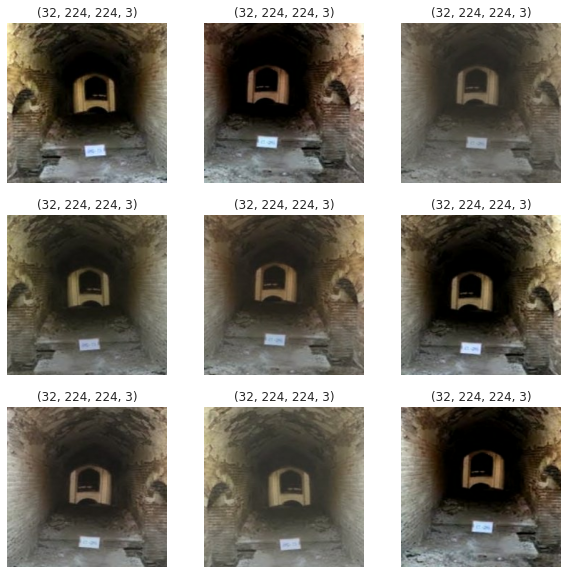

In [20]:
# method 1: using a func (inside can use both TF_funcs & keras_layers)
def data_augmentation_tf(img):
  '''
  tekboart's custome img augmentation pipline

  args:
    img: An image as a rank-4 tensor (NHWC)
    input_shape: a tuple (H, W, C)
    batch_size: the number of images in each batch

  returns:
    x: an augmented image tensor (with the same shape as input img)
  '''
  x = img

  # step 1: augment the color, brightness, contrast, saturation
  x = tf.image.random_brightness(x, max_delta=.05)
  x = tf.image.random_contrast(x, lower=.6, upper=1.2)
  x = tf.image.random_saturation(x, 0.75, 1.1)
  x = tf.image.random_hue(x, 0.03)
  
  # step 2: flip, crop, resize, center, change quality of the img
  x = tf.image.random_flip_left_right(x)
  # x = tfl.RandomRotation(0.02)(x)

  input_shape = img.shape
  crop_ratio = 0.9  # means keep 90% of the img (or crop 10% of img)
  if len(input_shape) == 3:
    H = input_shape[0]
    W = input_shape[1]
    C = input_shape[2]
    crop_H = int(H * crop_ratio)
    crop_W = int(W * crop_ratio)
    # do random crop
    x = tf.image.random_crop(x, size=(crop_H, crop_W, C))
    # resize and center the cropped image (as we changed the img size & center by random crop)
    num_cropped_pixels_H = H - crop_H
    num_cropped_pixels_W = W - crop_W
    # use 2* because i.e., in height we cropped some pixels (e.g., 16) from both top & bottom (hence a total of 2*16=32 pixels were cropped)
    x = tf.image.resize(x, ((H+2*num_cropped_pixels_H), (W+2*num_cropped_pixels_W)))
    x = x[num_cropped_pixels_H:-num_cropped_pixels_H, num_cropped_pixels_W:-num_cropped_pixels_W, :]
    # Randomly change jpeg encoding quality for inducing jpeg noise.
    x = tf.image.random_jpeg_quality(x, 80, 100)
  elif len(input_shape) == 4:
    N = input_shape[0]
    H = input_shape[1]
    W = input_shape[2]
    C = input_shape[3]
    crop_H = int(H * crop_ratio)
    crop_W = int(W * crop_ratio)
    x = tf.image.random_crop(x, size=(N, crop_H, crop_W, C))
    # resize and center the cropped image (as we changed the img size & center by random crop)
    num_cropped_pixels_H = H - crop_H
    num_cropped_pixels_W = W - crop_W
    # use 2* because i.e., in height we cropped some pixels (e.g., 16) from both top & bottom (hence a total of 2*16=32 pixels were cropped)
    x = tf.image.resize(x, ((H+2*num_cropped_pixels_H), (W+2*num_cropped_pixels_W)))
    x = x[:, num_cropped_pixels_H:-num_cropped_pixels_H, num_cropped_pixels_W:-num_cropped_pixels_W, :]

    # Randomly change jpeg encoding quality for inducing jpeg noise.
    x_new = tf.zeros([1, H, W, C], dtype=tf.float32)
    for i in range(N):
      img_ch_quality = tf.image.random_jpeg_quality(x[i], 80, 100)
      x_new = tf.concat([x_new, tf.expand_dims(img_ch_quality, 0)], axis=0)
    x = x_new[1:]

  return x

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = np.array(Image.open(grace_hopper).resize((input_shape[0], input_shape[1]))).astype(np.float32)/255.
image = np.expand_dims(grace_hopper, axis=0)
# plt.imshow(image[0])

# if images are [0..1] (normalized)
# images = next(iter(train_ds))[0]
# if images are [0..255]
images = next(iter(train_ds))[0]/255.

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_images = data_augmentation_tf(images)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0])
  plt.title(augmented_images.shape)
  plt.axis("off")

### data augmentation (in Keras)

2022-08-01 06:12:00.586170: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


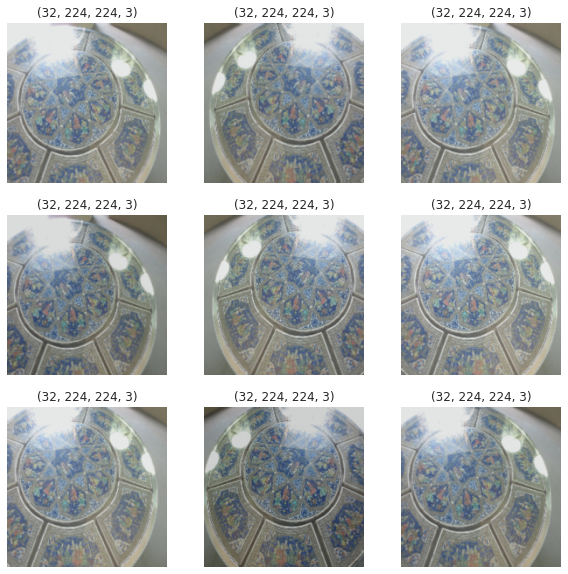

In [21]:
# method 2: using Keras Seq model
def img_augmentation_model(input_shape:tuple=None, value_range:tuple=(0.0, 255.0)) -> tf.keras.Sequential.__class__:
    '''
    augment img data to reduce overfitting and make the model more robust
    * pros of this model: using Keras for Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).

    arguments:
        input_shape: the shape of the input images (to this func)
        value_range: tuple of 2 floats for the lower and upper limit of the values of the input data. 
          * Defaults to [0.0, 255.0]. Can be changed to e.g. [0.0, 1.0] or [-1.0, 1.0] if the image input has been scaled before this layer.
          * The brightness adjustment will be scaled to this range, and the output values will be clipped to this range.

    returns:
        tf.keras.Sequential
    '''
    model = tf.keras.Sequential()
    model.add(tfl.RandomBrightness(factor=.1, value_range=value_range))
    model.add(tfl.RandomContrast(.6, 1.2))
    model.add(tfl.RandomFlip("horizontal"))
    model.add(tfl.RandomCrop(int(input_shape[0]*.9), int(input_shape[1]*.9)))
    # not so good as RandomCrop it's deterministic for the same H, W
    # model.add(tf.keras.layers.CenterCrop(int(input_shape[0]*.9), int(input_shape[1]*.9)))
    # model.add(tfl.RandomTranslation(.1, .1))
    # model.add(tfl.RandomZoom(0.9))
    model.add(tfl.RandomRotation(0.005))

    # resize back the augmented image to the input's shape
    # no need if use a preprocessing layer after it (to resize the inputs)
    model.add(tfl.Resizing(input_shape[0], input_shape[1]))
    return model

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = np.array(Image.open(grace_hopper).resize((input_shape[0], input_shape[1]))).astype(np.float32)/255.
images = np.expand_dims(grace_hopper, axis=0)
# plt.imshow(image[0])

# if images are [0..1] (normalized)
# images = next(iter(train_ds))[0]
# if images are [0..255]
images = next(iter(train_ds))[0]/255.

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_images = img_augmentation_model(input_shape, value_range=(0.0, 1.0))(images)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0])
  plt.title(augmented_images.shape)
  plt.axis("off")

In [23]:
def preprocess_img_model(input_shape:tuple=None, value_range:tuple=None) -> tf.keras.Sequential.__class__:
    '''
    preprocess the inputs (in train, evaluate and predict), so no need for data piplines (specially in prediction)

    arguments:
        input_shape: the shape of the input images (to this func)
        value_range: a tuple of floates define the final range, after normalization (should be either (-1.0, 1.0), (0.0, 1.0)
            * Note: If using other tf.keras.applications, be sure to check the API doc to determine if they expect pixels in [-1, 1] or [0, 1], 
            * if not sure can instead of this func use the included preprocess_input function (if any):
            e.g., preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    returns:
        tf.keras.Sequential
    '''
    model = tf.keras.Sequential()

    if input_shape:
        # we do resizing before normalization, 
        # as why normalizing a 1000x1000 input when we can do it for a 64x64 input?
        model.add(tfl.Resizing(input_shape[0], input_shape[1]))
    
    if range:
        if value_range == (-1.0, 1.0):
            model.add(tfl.Rescaling(1./127.5, offset=-1))
        elif value_range == (0.0, 1.0):
            model.add(tfl.Rescaling(1./255., offset=0))
    
    return model

## Create Model

### ResNet50

#### 1. Create a ResNet50 from scratch (with Functional API)

##### Create an IdentityBlock (with Functional API)
> Identity Block is a ResBlock in which the result of "main path" and the input (of main math) have the same shape

In [ ]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, training=True, drop_prob=0, lambda_=0):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    ## Set the padding = 'same'
    X = tfl.Conv2D(filters= F2, kernel_size=f, padding='same', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training = training) # Default axis
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)

    ## Third component of main path (≈2 lines)
    ## Set the padding = 'valid'
    X = tfl.Conv2D(filters= F3, kernel_size=1, kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = -1)(X, training = training) # Default axis
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)
    ### END CODE HERE

    return X

##### Create an Convolutional Block (with Functional API)
> Convolutional Block is a ResBlock in which the result of "main path" and the input (of main math) have the same shape

> I think this Convolution Block is the same as a Bottleneck Block (in MobileNet v2)

In [ ]:

# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, s = 2, training=True, drop_prob=0, lambda_=0):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)
    
    ## Second component of main path (≈3 lines)
    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)

    ## Third component of main path (≈2 lines)
    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_regularizer=tfr.l2(lambda_))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_regularizer=tfr.l2(lambda_))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)
    
    return X

##### Create the Final ResNet50

In [ ]:

# UNQ_C3
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape, drop_prob=0, l2_lambda=0):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = tf.keras.Input(input_shape)
    X = X_input

    # Zero-Padding
    X = tfl.ZeroPadding2D((3, 3))(X)
    
    # Stage 1
    X = tfl.Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tfl.Activation('relu')(X)
    X = tfl.Dropout(drop_prob)(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [64, 64, 256], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [64, 64, 256], drop_prob=drop_prob, lambda_=l2_lambda)
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [128, 128, 512], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [128, 128, 512], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [128, 128, 512], drop_prob=drop_prob, lambda_=l2_lambda)
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [256, 256, 1024], drop_prob=drop_prob, lambda_=l2_lambda)

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2, drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [512, 512, 2048], drop_prob=drop_prob, lambda_=l2_lambda)
    X = identity_block(X, 3, [512, 512, 2048], drop_prob=drop_prob, lambda_=l2_lambda)

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = tfl.AveragePooling2D(pool_size=(2, 2))(X)
    # X = tfl.Flatten()(X)

    # # # output layer
    # # X = tfl.Dense(classes, activation='softmax')(X)  # for multi-class classification
    # X = tfl.Dense(1, activation='sigmoid')(X)  # for binary classification
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = X)

    return model

##### Modifty the Final ResNet50 (from scratch)
> by adding preprocessing, data augmentation, output layer, regularization, etc.

In [ ]:
def tekboart_ResNet50(input_shape, classes=num_classes, drop_prob=0, l2_lambda=0, value_range=(0.0, 1.0)):
    '''
    instantiate a keras model with preprocessing, img augmentation, etc.
    '''
    inputs = tf.keras.Input(shape=input_shape)
    X = inputs

    # add data augmentation
    X = img_augmentation_model(input_shape, value_range=value_range)(X)

    # ResNet model (without output layer)
    X = ResNet50(input_shape, drop_prob=drop_prob, l2_lambda=l2_lambda)(X)

    # to collaps the output of the ResNetModel
    X = tfl.GlobalAveragePooling2D()(X)
    
    # add dropout regularization
    X = tfl.Dropout(drop_prob)(X)

    # flatten the layer into (m, n_x) format
    # BeCo the GlobalAveragePooling is not needed
    # X = tfl.Flatten()(X)

    # output layer
    # X = tfl.Dense(classes, activation='softmax')(X)  # for multi-class classification
    X = tfl.Dense(1, activation='sigmoid')(X)  # for binary classification
    outputs = X

    model = tf.keras.Model(inputs, outputs)
    return model

##### instantiate a ResNet50 model

In [ ]:
ResNet50_scratch = tekboart_ResNet50(input_shape=input_shape, classes=num_classes, drop_prob=0, l2_lambda=0)
# ResNet50_scratch = ResNet50(input_shape=input_shape, drop_prob=0, l2_lambda=0)

print(ResNet50_scratch.summary())
# tf.keras.utils.plot_model(ResNet50_scratch)

##### Train the ResNet50

In [ ]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss',
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
# # simple metrics
# metrics = ['accuracy']

# metrics for binary classification
metrics = [
    tfm.BinaryAccuracy(name='accuracy'),
    tfm.Precision(name='precision'),
    tfm.Recall(name='recall'),
    tfm.AUC(name='auc'),
    tfm.AUC(name='prc', curve='PR'),  # precision-recall curve
    tfm.TruePositives(name='tp'),
    tfm.FalsePositives(name='fp'),
    tfm.TrueNegatives(name='tn'),
    tfm.FalseNegatives(name='fn'),
]

# set LR_decay method
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

ResNet50_scratch.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                         metrics=metrics)

epochs = 5

ResNet50_scratch_history = ResNet50_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping],
    # class_weight=None)
    class_weight=class_weight)


##### Plot the training performance

In [ ]:
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'prc']
plot_metrics(ResNet50_scratch_history, metrics=metrics_names)
plt.show()

In [ ]:
test_predictions_baseline = ResNet50_scratch.predict(test_ds)
print(test_predictions_baseline.shape)

baseline_results = ResNet50_scratch.evaluate(test_ds, verbose=0)

for name, testue in zip(ResNet50_scratch.metrics_names, baseline_results):
  print(name, ': ', testue)
print()

# for binary classification
y_true = [elem[1].numpy() for elem in test_ds.unbatch()]
# print(y_true)
y_pred = test_predictions_baseline
# print(y_pred)

# for multi-class classification
# y_true = [tf.argmax(elem[1]).numpy() for elem in test_ds.unbatch()]
# # print(y_true)
# y_pred = tf.argmax(test_predictions_baseline, axis=1).numpy()
# # print(y_pred)

plot_cm(y_true, y_pred)

##### Test the ResNet50 (from scratch)

In [ ]:
preds_scratch = ResNet50_scratch.evaluate(val_ds, verbose=0)

print ("Test Loss = " + str(preds_scratch[0]))
print ("Test Accuracy = " + str(preds_scratch[1]))

##### predict with the ResNet50 (from scratch)

In [ ]:
# define the resize_shape
shape = ResNet50_scratch.input_shape
resize_shape = (shape[1], shape[2])

# define image address
# addr = '/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/0 Resized (max1000x1000)/Semnan (Resized)/76.JPG'
addr = "F:\Thesis Data\Pix\0 Model Ready Data\0 Resized (max1000x1000)\Semnan (Resized)\IMG_6669.JPG"

# prepare an img to be given to the model as input
img_file = Image.open(addr)
img_file_resized = img_file.resize(resize_shape)  # resize the img to the model's input_shape
img_tensor = tf.constant(np.array(img_file_resized))  # PIL ImageFile to TF tensor
img_tensor_norm = tf.cast(img_tensor, tf.float32) / 255.
img_final = tf.expand_dims(img_tensor_norm, axis=0)  # convert (H, W, C) --> (1, H, W, C)
print('img_final shape:', img_final.shape)

# do the prediction (only forward pass)
inference = ResNet50_scratch.predict(img_final, verbose=0)

print('the inference:\n', inference.round(2), sep="")
label = tf.argmax(inference.squeeze()).numpy()  # used .squeeze() since the shape of inference is (1, C)
plt.imshow(img_tensor_norm.numpy())
plt.title(f'predicted label = {label}')
plt.show

#### 2. Load a pretrained ResNet50
> we just use a pretrained ResNet50 (trained with ImageNet) to do transfer learning

In [ ]:
# ResNet50_pretrained = tf.keras.models.load_model('/run/media/tekboart/SP 2TB/CE - CS/Development/Exercise/00 Resources/Models/resnet50.h5')
ResNet50v2_pretrained = tf.keras.applications.ResNet50V2(input_shape=input_shape, include_top=False, weights='imagenet')

In [ ]:
def tl_model_builder(pretrained_model, input_shape, drop_prob=0, value_range=(0.0, 1.0)):
    # freeze the classification phase layers (use them only for feature extraction)
    pretrained_model.trainable = False

    # build a model (on top of the base/pretrained model)
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # preprocess the data (resize, normalize, etc.)
    x = preprocess_img_model(input_shape, value_range=value_range)(x)

    # data img augmentation model
    # must be after preprocess layer, as the tfl.RandomBrightness needs to know the value_range of inputs
    x = img_augmentation_model(input_shape, value_range=value_range)(x)

    # the base/pretrained model
    x = pretrained_model(x, training=False)

    # to collapse the output of base/pretrained model
    # does the Flattening as well
    x = tfl.GlobalAveragePooling2D()(x)  

    # to add regularization
    x = tfl.Dropout(drop_prob)(x)  

    # output layer
    # x = tfl.Dense(num_classes, activation='softmax')(x)  # for multi-class classification
    x = tfl.Dense(1, activation='sigmoid')(x)  # for binary classification
    outputs = x

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
# instantiate a Transfer Learning Model
ResNet50v2_tl = tl_model_builder(ResNet50v2_pretrained, input_shape=input_shape, drop_prob=0, value_range=(-1.0, 1.0))

In [ ]:
# compile the model

# # simple metrics
# metrics = ['accuracy']

# metrics for binary classification
metrics = [
    tfm.BinaryAccuracy(name='accuracy'),
    tfm.Precision(name='precision'),
    tfm.Recall(name='recall'),
    tfm.AUC(name='auc'),
    tfm.AUC(name='prc', curve='PR'),  # precision-recall curve
    tfm.TruePositives(name='tp'),
    tfm.FalsePositives(name='fp'),
    tfm.TrueNegatives(name='tn'),
    tfm.FalseNegatives(name='fn'),
]

# set LR_decay method
base_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

ResNet50v2_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=metrics)

In [ ]:
# check the performance of pretrained model (before training the added layers)
loss0, accuracy0, *_ = ResNet50v2_tl.evaluate(val_ds, verbose=0)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

##### Train the added layers 
> to the pretrained ResNet50v2

In [ ]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss',
    monitor='val_prc',
    verbose=0,
    patience=5,
    mode='auto',
    restore_best_weights=True)

In [ ]:
initial_epochs = 50

ResNet50v2_tl_history = ResNet50v2_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=[early_stopping],
    # class_weight=None)
    class_weight=class_weight)

##### Plot the training performance

In [ ]:
# metrics_names = ['loss', 'accuracy']
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'prc']
plot_metrics(ResNet50v2_tl_history, metrics=metrics_names)
plt.show()

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(ResNet50v2_pretrained.layers))

##### Fine-tune the top layers (of the base/pretrained model)

In [ ]:
#  unfreeze the base_model
ResNet50v2_pretrained.trainable = True

# set the bottom layers to be un-trainable.
# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in ResNet50v2_pretrained.layers[:fine_tune_at]:
  layer.trainable = False

# recompile the model (necessary for these changes to take effect)
# As you are training a much larger model and want to readapt the pretrained weights, 
# it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
ResNet50v2_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=metrics)

In [ ]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss',
    monitor='val_prc',
    verbose=0,
    patience=5,
    mode='auto',
    restore_best_weights=True)

In [ ]:
# resume training
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

ResNet50v2_tl_finetune_history = ResNet50v2_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=ResNet50v2_tl_history.epoch[-1],
    callbacks=[early_stopping],
    class_weight=None)
    # class_weight=class_weight)

##### Plot the training performance

In [ ]:
# metrics_names = ['loss', 'accuracy']
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'prc']
plot_metrics(ResNet50v2_tl_finetune_history, metrics=metrics_names)
plt.show()

In [ ]:
# aggregate the performance measures before & after fine-tuning
acc = ResNet50v2_tl_history.history['accuracy'] + ResNet50v2_tl_finetune_history.history['accuracy']
val_acc = ResNet50v2_tl_history.history['val_accuracy'] + ResNet50v2_tl_finetune_history.history['val_accuracy']

loss = ResNet50v2_tl_history.history['loss'] + ResNet50v2_tl_finetune_history.history['loss']
val_loss = ResNet50v2_tl_history.history['val_loss'] + ResNet50v2_tl_finetune_history.history['val_loss']

#plot
# the horizontal scale of plots are incorrect as we used early stopping
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Test the Model (ResNet50v2_tl)

In [ ]:
# train_predictions_baseline = ResNet50v2_tl.predict(train_ds)
# val_predictions_baseline = ResNet50v2_tl.predict(val_ds)
test_predictions_baseline = ResNet50v2_tl.predict(test_ds)
print(test_predictions_baseline.shape)

baseline_results = ResNet50v2_tl.evaluate(test_ds, verbose=0)

print('Test set metrics:')
for name, value in zip(ResNet50v2_tl.metrics_names, baseline_results):
  print('  ', name, ': ', value)
print()

# for binary classification
y_true = [elem[1].numpy() for elem in test_ds.unbatch()]
# print(y_true)
y_pred = test_predictions_baseline
# print(y_pred)

# for multi-class classification
# y_true = [tf.argmax(elem[1]).numpy() for elem in test_ds.unbatch()]
# # print(y_true)
# y_pred = tf.argmax(test_predictions_baseline, axis=1).numpy()
# # print(y_pred)

plot_cm(y_true, y_pred)

##### predict with the ResNet50v2_tl

In [ ]:
# define the resize_shape
shape = ResNet50v2_tl.input_shape
resize_shape = (shape[1], shape[2])

# define image address
addr = '/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/0 Resized (max1000x1000)/Semnan (Resized)/75.JPG'
# addr = "F:\Thesis Data\Pix\0 Model Ready Data\0 Resized (max1000x1000)\Semnan (Resized)\IMG_6669.JPG"

# prepare an img to be given to the model as input
img_file = Image.open(addr)
img_file_resized = img_file.resize(resize_shape)  # resize the img to the model's input_shape
img_tensor = tf.constant(np.array(img_file_resized))  # PIL ImageFile to TF tensor
img_tensor_norm = tf.cast(img_tensor, tf.float32) / 255.
img_final = tf.expand_dims(img_tensor_norm, axis=0)  # convert (H, W, C) --> (1, H, W, C)
print('img_final shape:', img_final.shape)

# do the prediction (only forward pass)
inference = ResNet50v2_tl.predict(img_final, verbose=0)

print('the inference:\n', inference.round(2), sep="")

if inference.squeeze() < .5:
    confidence = (1. - inference.squeeze()).round(2)
    print('confidence:\n', confidence)
else:
    confidence =  inference.squeeze().round(2)
    print('confidence:\n', confidence)

# for binary classification 
label = (inference.squeeze()).round()  # used .squeeze() since the shape of inference is (1, C)
# for multi-class classification 
# label = tf.argmax(inference.squeeze()).numpy()  # used .squeeze() since the shape of inference is (1, C)

plt.imshow(img_tensor_norm.numpy())
plt.title(f'predicted label = {label}, conf={confidence}')
plt.show

### MobileNet

#### 3. Load a pretrained MobileNet
> we just use a pretrained MobileNet (trained with ImageNet) to do transfer learning

In [138]:
MobileNetv3_pretrained = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


# load the preprocessing of the base/pretrained model (i.e., MobileNet) (the ResNet50V2 didn't have it)
# preprocess_input = ResNet50v2_pretrained.preprocess_input
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [139]:
def tl_model_builder(pretrained_model, input_shape, drop_prob=0, value_range=(0.0, 1.0)):
    # freeze the classification phase layers (use them only for feature extraction)
    pretrained_model.trainable = False

    # build a model (on top of the base/pretrained model)
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # preprocess the data (resize, normalize, etc.)
    # tekboart preprocess model
    x = preprocess_img_model(input_shape, value_range=value_range)(x)
    # mobilenet_v3's own preprocess
    # x = preprocess_input(x)

    # data img augmentation model
    # must be after preprocess layer, as the tfl.RandomBrightness needs to know the value_range of inputs
    x = img_augmentation_model(input_shape, value_range=value_range)(x)

    # the base/pretrained model
    x = pretrained_model(x, training=False)

    # to collapse the output of base/pretrained model
    # does the Flattening as well
    x = tfl.GlobalAveragePooling2D()(x)  

    # to add regularization
    x = tfl.Dropout(drop_prob)(x)  

    # output layer
    # x = tfl.Dense(num_classes, activation='softmax')(x)  # for multi-class classification
    x = tfl.Dense(1, activation='sigmoid')(x)  # for binary classification
    outputs = x

    model = tf.keras.Model(inputs, outputs)
    return model

In [140]:
# instantiate a Transfer Learning Model
MobileNetv3_tl = tl_model_builder(MobileNetv3_pretrained, input_shape=input_shape, drop_prob=0.2, value_range=(-1.0, 1.0))

In [141]:
# compile the model

# # simple metrics
# metrics = ['accuracy']

# metrics for binary classification
metrics = [
    tfm.BinaryAccuracy(name='accuracy'),
    tfm.Precision(name='precision'),
    tfm.Recall(name='recall'),
    tfm.AUC(name='auc'),
    tfm.AUC(name='prc', curve='PR'),  # precision-recall curve
    tfm.TruePositives(name='tp'),
    tfm.FalsePositives(name='fp'),
    tfm.TrueNegatives(name='tn'),
    tfm.FalseNegatives(name='fn'),
]

# set LR_decay method
base_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

MobileNetv3_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=metrics)

In [142]:
# check the performance of pretrained model (before training the added layers)
loss0, accuracy0, *_ = MobileNetv3_tl.evaluate(val_ds, verbose=0)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.12
initial accuracy: 0.42


##### Train the added layers 
> to the pretrained Model

In [146]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # monitor='val_prc',
    verbose=0,
    patience=5,
    mode='auto',
    restore_best_weights=True)

In [147]:
initial_epochs = 20

MobileNetv3_tl_history = MobileNetv3_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=[early_stopping],
    # class_weight=None)
    class_weight=class_weight)

Epoch 1/20
44/44 [==============================] - 6s 146ms/step - loss: 0.5569 - accuracy: 0.7264 - precision: 0.8199 - recall: 0.7374 - auc: 0.7882 - prc: 0.8651 - tp: 660.0000 - fp: 145.0000 - tn: 349.0000 - fn: 235.0000 - val_loss: 0.4870 - val_accuracy: 0.7880 - val_precision: 0.8405 - val_recall: 0.8012 - val_auc: 0.8416 - val_prc: 0.8848 - val_tp: 137.0000 - val_fp: 26.0000 - val_tn: 86.0000 - val_fn: 34.0000
Epoch 2/20
44/44 [==============================] - 6s 147ms/step - loss: 0.4786 - accuracy: 0.7711 - precision: 0.8505 - recall: 0.7821 - auc: 0.8520 - prc: 0.9066 - tp: 700.0000 - fp: 123.0000 - tn: 371.0000 - fn: 195.0000 - val_loss: 0.4569 - val_accuracy: 0.7915 - val_precision: 0.8373 - val_recall: 0.8129 - val_auc: 0.8632 - val_prc: 0.9033 - val_tp: 139.0000 - val_fp: 27.0000 - val_tn: 85.0000 - val_fn: 32.0000
Epoch 3/20
44/44 [==============================] - 6s 146ms/step - loss: 0.4837 - accuracy: 0.7574 - precision: 0.8514 - recall: 0.7553 - auc: 0.8457 - prc: 

##### Plot the training performance

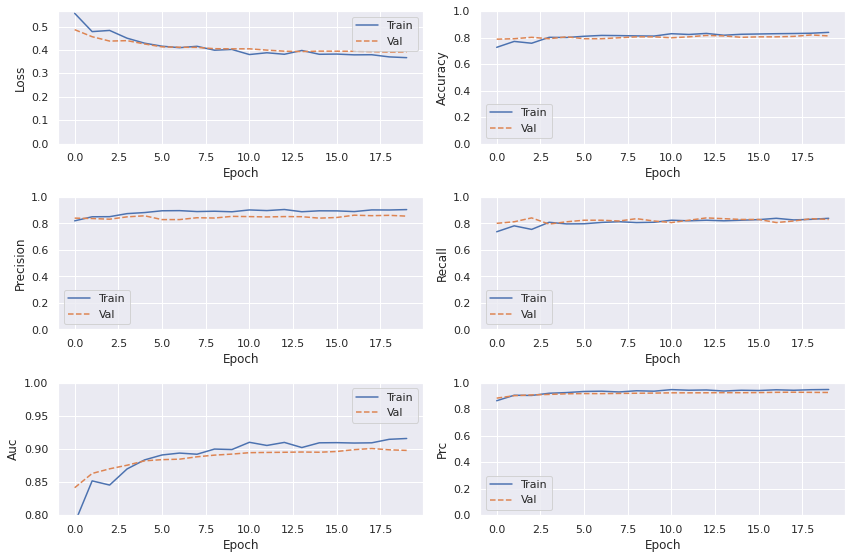

In [148]:
# metrics_names = ['loss', 'accuracy']
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'prc']
# metrics_names = MobileNetv3_tl.metrics_names
plot_metrics(MobileNetv3_tl_history, metrics=metrics_names)
plt.show()

##### Fine-tune the top layers (of the base/pretrained model)

In [149]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(MobileNetv3_pretrained.layers))

Number of layers in the base model:  154


In [156]:
#  unfreeze the base_model
MobileNetv3_pretrained.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# set the bottom layers to be un-trainable.
# Freeze all the layers before the `fine_tune_at` layer
for layer in MobileNetv3_pretrained.layers[:fine_tune_at]:
  layer.trainable = False

# recompile the model (necessary for these changes to take effect)
# As you are training a much larger model and want to readapt the pretrained weights, 
# it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
MobileNetv3_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=metrics)

In [157]:
# set the callback for early stopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # monitor='val_prc',
    verbose=0,
    patience=5,
    mode='auto',
    restore_best_weights=True)

In [158]:
# resume training
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

MobileNetv3_tl_finetune_history = MobileNetv3_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=MobileNetv3_tl_history.epoch[-1],
    callbacks=[early_stopping],
    # class_weight=None)
    class_weight=class_weight)

Epoch 20/30
44/44 [==============================] - 14s 197ms/step - loss: 0.1318 - accuracy: 0.9199 - precision: 0.9641 - recall: 0.9081 - auc: 0.9788 - prc: 0.9884 - tp: 968.0000 - fp: 36.0000 - tn: 570.0000 - fn: 98.0000 - val_loss: 0.3331 - val_accuracy: 0.8728 - val_precision: 0.9141 - val_recall: 0.8713 - val_auc: 0.9400 - val_prc: 0.9592 - val_tp: 149.0000 - val_fp: 14.0000 - val_tn: 98.0000 - val_fn: 22.0000
Epoch 21/30
44/44 [==============================] - 8s 171ms/step - loss: 0.1078 - accuracy: 0.9575 - precision: 0.9805 - recall: 0.9531 - auc: 0.9939 - prc: 0.9968 - tp: 853.0000 - fp: 17.0000 - tn: 477.0000 - fn: 42.0000 - val_loss: 0.3370 - val_accuracy: 0.8763 - val_precision: 0.9000 - val_recall: 0.8947 - val_auc: 0.9384 - val_prc: 0.9534 - val_tp: 153.0000 - val_fp: 17.0000 - val_tn: 95.0000 - val_fn: 18.0000
Epoch 22/30
44/44 [==============================] - 8s 172ms/step - loss: 0.1027 - accuracy: 0.9525 - precision: 0.9825 - recall: 0.9430 - auc: 0.9943 - prc: 

##### Plot the training performance

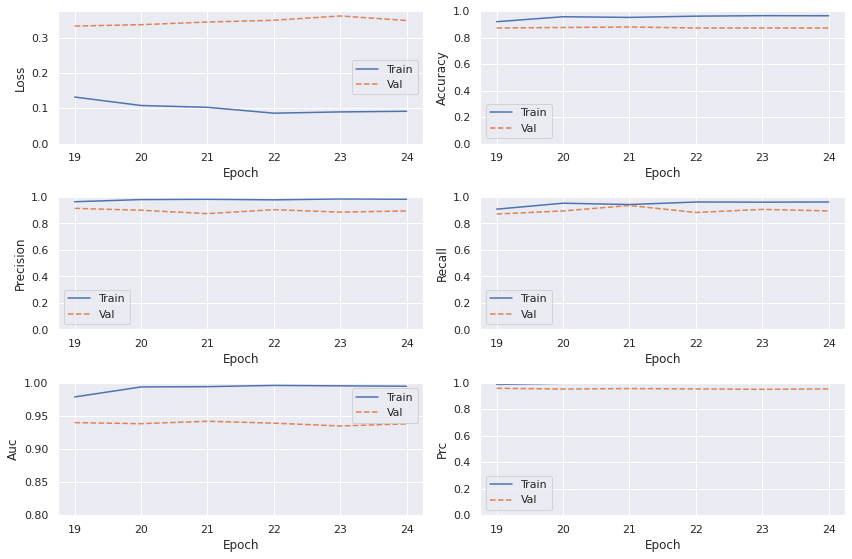

In [159]:
# metrics_names = ['loss', 'accuracy']
metrics_names = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'prc']
# metrics_names = MobileNetv3_tl.metrics_names
plot_metrics(MobileNetv3_tl_finetune_history, metrics=metrics_names)
plt.show()

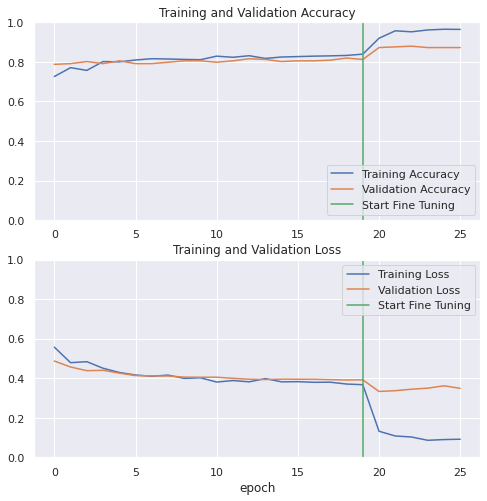

In [160]:
# aggregate the performance measures before & after fine-tuning
acc = MobileNetv3_tl_history.history['accuracy'] + MobileNetv3_tl_finetune_history.history['accuracy']
val_acc = MobileNetv3_tl_history.history['val_accuracy'] + MobileNetv3_tl_finetune_history.history['val_accuracy']

loss = MobileNetv3_tl_history.history['loss'] + MobileNetv3_tl_finetune_history.history['loss']
val_loss = MobileNetv3_tl_history.history['val_loss'] + MobileNetv3_tl_finetune_history.history['val_loss']

#plot
# the horizontal scale of plots are incorrect as we used early stopping
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Test the Model (MobileNetv3_tl)

2/2 [==============================] - 1s 49ms/step
(64, 1)
Test set metrics:
   loss :  0.17202624678611755
   accuracy :  0.9375
   precision :  0.9743589758872986
   recall :  0.9268292784690857
   auc :  0.9830328226089478
   prc :  0.9908287525177002
   tp :  38.0
   fp :  1.0
   tn :  22.0
   fn :  3.0



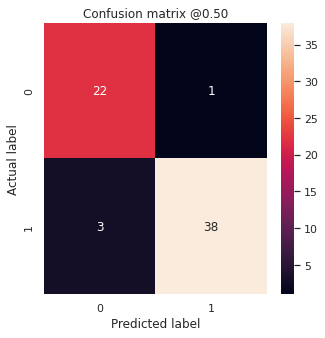

In [161]:
# train_predictions_baseline = MobileNetv3_tl.predict(train_ds)
# val_predictions_baseline = MobileNetv3_tl.predict(val_ds)
test_predictions_baseline = MobileNetv3_tl.predict(test_ds)
print(test_predictions_baseline.shape)

baseline_results = MobileNetv3_tl.evaluate(test_ds, verbose=0)

print('Test set metrics:')
for name, value in zip(MobileNetv3_tl.metrics_names, baseline_results):
  print('  ', name, ': ', value)
print()

# for binary classification
y_true = [elem[1].numpy() for elem in test_ds.unbatch()]
# print(y_true)
y_pred = test_predictions_baseline
# print(y_pred)

# for multi-class classification
# y_true = [tf.argmax(elem[1]).numpy() for elem in test_ds.unbatch()]
# # print(y_true)
# y_pred = tf.argmax(test_predictions_baseline, axis=1).numpy()
# # print(y_pred)

plot_cm(y_true, y_pred)

##### predict with the MobileNetv3_tl

img_final shape: (1, 224, 224, 3)
the inference:
[[0.44]]
confidence:
 0.56


<function matplotlib.pyplot.show(close=None, block=None)>

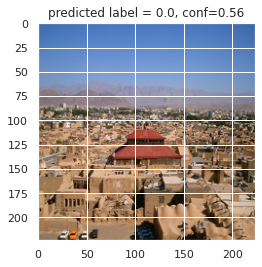

In [115]:
# define the resize_shape
shape = MobileNetv3_tl.input_shape
resize_shape = (shape[1], shape[2])

# define image address
addr = '/run/media/tekboart/SP 2TB/Thesis Data/Pix/0 Model Ready Data/0 Resized (max1000x1000)/Semnan (Resized)/75.JPG'
# addr = "F:\Thesis Data\Pix\0 Model Ready Data\0 Resized (max1000x1000)\Semnan (Resized)\IMG_6669.JPG"

# prepare an img to be given to the model as input
img_file = Image.open(addr)
img_file_resized = img_file.resize(resize_shape)  # resize the img to the model's input_shape
img_tensor = tf.constant(np.array(img_file_resized))  # PIL ImageFile to TF tensor
img_tensor_norm = tf.cast(img_tensor, tf.float32) / 255.
img_final = tf.expand_dims(img_tensor_norm, axis=0)  # convert (H, W, C) --> (1, H, W, C)
print('img_final shape:', img_final.shape)

# do the prediction (only forward pass)
inference = MobileNetv3_tl.predict(img_final, verbose=0)

print('the inference:\n', inference.round(2), sep="")

if inference.squeeze() < .5:
    confidence = (1. - inference.squeeze()).round(2)
    print('confidence:\n', confidence)
else:
    confidence =  inference.squeeze().round(2)
    print('confidence:\n', confidence)

# for binary classification 
label = (inference.squeeze()).round()  # used .squeeze() since the shape of inference is (1, C)
# for multi-class classification 
# label = tf.argmax(inference.squeeze()).numpy()  # used .squeeze() since the shape of inference is (1, C)

plt.imshow(img_tensor_norm.numpy())
plt.title(f'predicted label = {label}, conf={confidence}')
plt.show

#### 3. Comapre all the models
> in terms of Loss, Accuracy, etc.

In [ ]:
print("ResNet50 (scratch)".center(79, '-'))
print("Loss = " + str(ResNet50_scratch_history.history[0]))
print("Test Accuracy = " + str(ResNet50_scratch_history[1]))

print("ResNet50v2 (Transfer Learning)".center(79, '-'))
print("Loss = " + str(ResNet50v2_tl_finetune_history[0]))
print("Test Accuracy = " + str(ResNet50v2_tl_finetune_history[1]))

print("MobileNetv3 (Transfer Learning)".center(79, '-'))
print("Loss = " + str(MobileNetv3_tl_finetune_history[0]))
print("Test Accuracy = " + str(MobileNetv3_tl_finetune_history[1]))


models_history = {'ResNet50_scratch': ResNet50_scratch_history,
                  'ResNet50v2_tl': ResNet50v2_tl_finetune_history,
                  'MobileNetv3_tl': MobileNetv3_tl_finetune_history}

for i in range(2):
    plt.subplot(1, 2, i+1)
    model_history = models_history.items()[i]
    for history in models_history:
        plt.bar(history, models_history[history]['loss'], width=1)
    plt.xlabel('Model')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.show()

# plt.bar('ResNet50 (scratch)', preds_scratch[1], width=1)
# plt.bar('ResNet50 (pre-trained)', preds_pretrained[1], width=1)
# plt.xlabel('Model')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)
# plt.show()


# # using pandas + seaborn
# df = pd.DataFrame({'set': ['train', 'train', 'val', 'val', 'test', 'test'], 'label': ['NO', 'YES']*3, 'recs': x})
# # display(df)

# g = sns.catplot(
#     data=df,
#     x="set",
#     y="recs",
#     hue="label",
#     kind="bar",
#     height=5,
#     ci="sd",
#     # palette='husl', # set the color palette
#     # alpha=0.6,  # set the opacity
# )

# sns.set(style="darkgrid")
# g.despine(left=True)
# g.set_axis_labels("", "#images\n", fontsize=14)
# # g.legend.set_title("class/label", )
# g._legend.remove()  # to remove sns automatic legend (and use matplot's)
# plt.legend(loc='upper right', title='Class/Label')
# plt.show()


1. although the pretrained ResNet50 has scored slightly lower than the from scratch ResNet50, but:
* the pretrained model was trained with ImageNet but we tested it with sign dataset, so the results are great
* faster (than ResNet50 from scratch) as we didn't spend time training it 
2. if we have the time, computational power and a large dataset to train a model from scratch, then the results would be better (at least slightly)
> but <u>maybe</u> with transfer learning (especially with a small dataset) we can fare better
